In [6]:
import json
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd 

In [7]:
plt.style.use('ggplot')
sns.set(style='ticks')
# pandas defaults
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
# color default
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
color_list = [CB91_Blue, CB91_Green, CB91_Pink, CB91_Purple, CB91_Violet, CB91_Amber]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

In [8]:
import seaborn as sns
plt.style.use('ggplot')
sns.set(style='ticks')
sns.set_style("darkgrid")

# Load-in Enhanced dataset

In [9]:
# import dataset json file after preprocess mfccs
with open("MFCCs_data.json", "r") as fp:
    data = json.load(fp)

    # convert list into numpy arrays
    X = np.array(data['mfcc'])
    y = np.array(data['labels'])

In [10]:
# Double check labels from data file
data['mapping']

['killer_whale',
 'short_finned_pilot_whale',
 'FKW_enhanced',
 'humpback',
 'sperm_whale',
 'white_side_dolphine',
 'bowhead_enhanced',
 'risso_dolphin',
 'north_right_whale']

In [11]:
# Check class counts and that labels are numerical order
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([2399, 1400, 1260, 1900, 2100, 1670, 1350, 1520, 1100]))

In [12]:
def prepare_datasets(X, y2, test_size, validation_size):
    
    # load in the data
#     X, y = load_data(DATASET_PATH)
    
    # create the train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=test_size)
    
    # create the train/validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    
    # Tensorflow for CNN expect a 3D array -> (130, 13, 1) audio grayscale images
    X_train = X_train[..., np.newaxis] # 4d array -> (num of samples, 130, 13, 1)
    X_validation = X_validation[..., np.newaxis] 
    X_test = X_test[..., np.newaxis] 
    
    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [13]:
# create train, validation and test sets

X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(X, y, 0.25, 0.2) # test size, vailidation size

# Build the model

In [25]:

def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    # Save image
    fig.subplots_adjust(hspace=0.5)
    plt.savefig('/Users/javonnii/dolby_io/acc_loss_metrics.png', bbox_inches='tight')
    plt.show()

In [26]:
def build_model(input_shape):
    
    # Instantiate model
    model = keras.Sequential()
    
    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2,2), padding='same'))
    model.add(keras.layers.BatchNormalization()) # normalizes the activation at the layer, speeds up training
              
    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2,2), padding='same'))
    model.add(keras.layers.BatchNormalization())
                  
              
    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((2, 2), strides=(2,2), padding='same'))
    model.add(keras.layers.BatchNormalization())
              
    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten()) # flatten conv output
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3)) # randomly drops neurons
            
    # output layer that uses softmax
    model.add(keras.layers.Dense(9, activation='softmax')) # number of neurons of the classifications we want to predict
    
    print(model.summary())
    
    return model

In [27]:
# build the cnn net
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model = build_model(input_shape)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 11, 32)       320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 6, 32)         0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 6, 32)         128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 62, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 2, 32)         0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 31, 2, 32)         128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 1, 32)        

In [28]:
# compile the network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, 
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

Epoch 1/40
276/276 [==============================] - 8s 29ms/step - loss: 1.8471 - accuracy: 0.3677 - val_loss: 1.2025 - val_accuracy: 0.5995
Epoch 2/40
276/276 [==============================] - 8s 28ms/step - loss: 1.1953 - accuracy: 0.5829 - val_loss: 0.8390 - val_accuracy: 0.7134
Epoch 3/40
276/276 [==============================] - 8s 28ms/step - loss: 0.9709 - accuracy: 0.6628 - val_loss: 0.6683 - val_accuracy: 0.7810
Epoch 4/40
276/276 [==============================] - 8s 28ms/step - loss: 0.8134 - accuracy: 0.7217 - val_loss: 0.5619 - val_accuracy: 0.8186
Epoch 5/40
276/276 [==============================] - 8s 28ms/step - loss: 0.7037 - accuracy: 0.7537 - val_loss: 0.4844 - val_accuracy: 0.8444
Epoch 6/40
276/276 [==============================] - 8s 28ms/step - loss: 0.6285 - accuracy: 0.7855 - val_loss: 0.4542 - val_accuracy: 0.8535
Epoch 7/40
276/276 [==============================] - 8s 28ms/step - loss: 0.5613 - accuracy: 0.8106 - val_loss: 0.3791 - val_accuracy: 0.8780

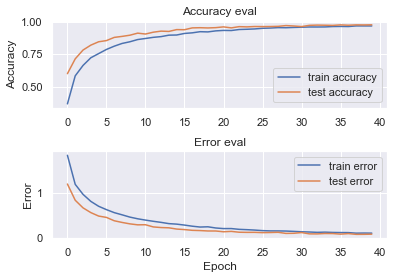

In [29]:
# Train the cnn 
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=40)

# plot accuracy/error for training and validation
plot_history(history)

In [30]:
# evaluate the cnn on the test set

test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy on test set is: {}".format(test_accuracy))

115/115 [==============================] - 1s 6ms/step - loss: 0.0740 - accuracy: 0.9755
Accuracy on test set is: 0.9755101799964905


# Confusion Matrix

In [31]:
# iterate each sample of X_test, predict, and store predicted index into a numpy array.

ypred_array = np.array([])

for i in range(len(X_test)):
    X = X_test[i]
    X = X[np.newaxis, ...] # to make a 4D
    
    # prediction
    prediction = model.predict(X)
    
    # extract the index with the max value
    predicted_index = np.argmax(prediction, axis=1)
    ypred_array = np.append(ypred_array, predicted_index)

print(ypred_array)

[4. 3. 5. ... 3. 7. 4.]


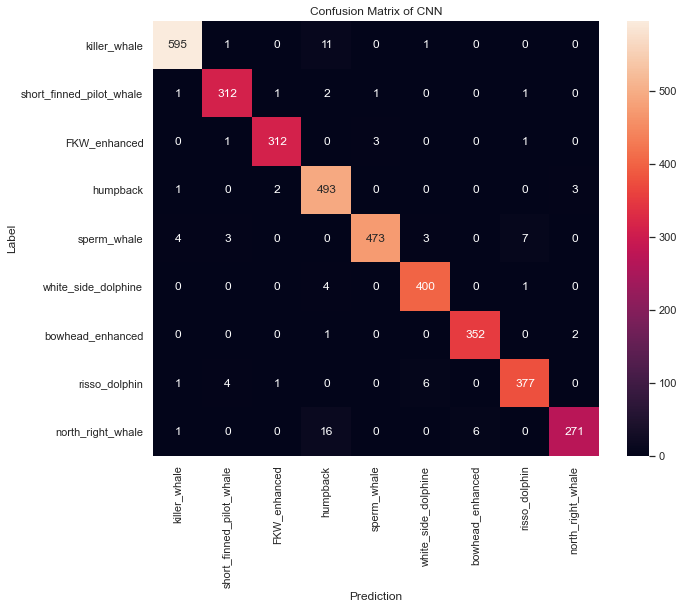

In [32]:
confusion_mtx = tf.math.confusion_matrix(y_test, ypred_array) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=data['mapping'], yticklabels=data['mapping'], 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title("Confusion Matrix of CNN")
plt.savefig('/Users/javonnii/dolby_io/finalCFcnn.png', bbox_inches='tight')
plt.show();

# Predict a sample

In [33]:
def predict(model, X, y):
    X = X[np.newaxis, ...] # to put make a 4D
    
    # prediction = [ [0.1, 0.2, ...] ] result of the softmax
    prediction = model.predict(X) # X -> (130, 13, 1) but expect 4D i.e num samples (1, 130, 13, 1)
    
    # extract the index with the max value
    predicted_index = np.argmax(prediction, axis=1) # [idx] 
    print("Expected index: {}, Predicted index: {}".format(y, predicted_index))
#     print(X.shape)
    

In [34]:
# make a prediction on a sample
X = X_test[65]
y = y_test[65]

predict(model, X, y)

Expected index: 0, Predicted index: [0]


# Save the model

In [35]:
# make a directory for saved models
# ! mkdir -p saved_model

In [38]:
# save the entire model
model.save('saved_model/FinalCnnModel6')

INFO:tensorflow:Assets written to: saved_model/FinalCnnModel6/assets
